# Imports & Paths

In [1]:
from PIL import Image
from google.colab import userdata
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
try:
    from torchinfo import summary as info
except:
    !pip install torchinfo
    from torchinfo import summary as info

import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn

import json
import os
import torch

# Set the multiprocessing start method to 'spawn' for CUDA compatibility
# This should be done at the very beginning of your script, before any multiprocessing is started.
import torch.multiprocessing as mp
if __name__ == '__main__':
    try:
        mp.set_start_method('spawn', force=True) # Added force=True to override if already set
    except RuntimeError:
        # This happens if the start method is already set, which is fine.
        pass


from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    print(line)
    return

In [2]:
project_path = userdata.get('PATH_PROJECT')
dataset_path = os.path.join(project_path, 'dataset')

train_path = os.path.join(dataset_path, 'train_metadata.json')
test_path = os.path.join(dataset_path, 'test_metadata.json')

import sys
src_path = os.path.join(project_path, 'src')
sys.path.append(src_path)

%load_ext autoreload
%autoreload 2

# The Data & The Dataset Class

In [3]:
with open(train_path) as train, open(test_path) as test:
    train_samples = json.load(train)
    test_samples = json.load(test)

# Get the scores for the training and testing sets
train_scores = [sample['score'] for sample in train_samples]
test_scores = [sample['score'] for sample in test_samples]

# Calculate the distribution of scores
train_score_distribution = pd.Series(train_scores).value_counts().sort_index()
test_score_distribution = pd.Series(test_scores).value_counts().sort_index()

# Display the distributions
print("Train set score distribution:")
display(train_score_distribution)

print("\nTest set score distribution:")
display(test_score_distribution)

Train set score distribution:


,count
0.0,1594
0.5,497
1.0,867



Test set score distribution:


,count
0.0,389
0.5,127
1.0,224


In [4]:
%%skip Mean: tensor([0.5201, 0.4945, 0.4692]) Std: tensor([0.2581, 0.2339, 0.2377])

from PairedImageDataset import PairedImageDataset
import torch
from tqdm import tqdm

temp_dataset = PairedImageDataset(root_dir=dataset_path, metadata_json_path=train_path, preload=False, device='cpu')
# Create a dataloader for calculating mean and std
temp_dataloader = DataLoader(temp_dataset, batch_size=64, shuffle=False, num_workers=2)

n_pixels = 0
sum_ = torch.zeros(3)
sum_sq = torch.zeros(3)

for img_clean, img_other, _ in tqdm(temp_dataloader, desc="Calculating Mean and STD..."):
    # [2B, C, H, W]
    images = torch.cat((img_clean, img_other), dim=0)
    sum_ += images.sum(dim=[0, 2, 3])
    sum_sq += (images ** 2).sum(dim=[0, 2, 3])

# Compute mean and std
n_pixels = len(temp_dataset) * 2 * 20 * 20 # len(temp_dataset) pairs, each 20x20
mean = sum_ / n_pixels
std = torch.sqrt(sum_sq / n_pixels - mean ** 2)

print("\nMean:", mean)
print("Std:", std)


Mean: tensor([0.5201, 0.4945, 0.4692]) Std: tensor([0.2581, 0.2339, 0.2377])


In [5]:
from PairedImageDataset import PairedImageDataset

# Define the device: GPU if available, CPU otherwise
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TRAIN_MEANS = torch.tensor([0.5201, 0.4945, 0.4692])
TRAIN_STDS = torch.tensor([0.2581, 0.2339, 0.2377])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=TRAIN_MEANS, std=TRAIN_STDS),
])

# Create dataset instances
train_dataset = PairedImageDataset(root_dir=dataset_path, metadata_json_path=train_path,
                                   preload=True, device=device, transform=transform
                                   )
test_dataset = PairedImageDataset(root_dir=dataset_path, metadata_json_path=test_path,
                                  preload=True, device=device, transform=transform
                                  )

# Create dataloader instances
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=2)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")

Preloading dataset to cuda...
sample 2958/2958
Preloading complete.
Preloading dataset to cuda...
sample 740/740
Preloading complete.
Number of training samples: 2958
Number of testing samples: 740
Batch size: 32


# Model & Training

## Model

In [217]:
from models import ImageComparisonModel_mk4 as ImageComparisonModel

# Instantiate the model
model = ImageComparisonModel()
display(info(model, input_size=[(1, 3, 20, 20), (1, 3, 20, 20)], device='cpu'))

Layer (type:depth-idx)                   Output Shape              Param #
ImageComparisonModel_mk4                 [1]                       --
├─Sequential: 1-1                        [1, 48, 5, 5]             --
│    └─Conv2d: 2-1                       [1, 16, 20, 20]           880
│    └─BatchNorm2d: 2-2                  [1, 16, 20, 20]           32
│    └─ReLU: 2-3                         [1, 16, 20, 20]           --
│    └─Conv2d: 2-4                       [1, 16, 20, 20]           2,320
│    └─BatchNorm2d: 2-5                  [1, 16, 20, 20]           32
│    └─ReLU: 2-6                         [1, 16, 20, 20]           --
│    └─MaxPool2d: 2-7                    [1, 16, 10, 10]           --
│    └─Conv2d: 2-8                       [1, 24, 10, 10]           3,480
│    └─BatchNorm2d: 2-9                  [1, 24, 10, 10]           48
│    └─ReLU: 2-10                        [1, 24, 10, 10]           --
│    └─Conv2d: 2-11                      [1, 24, 10, 10]           5,208
│    

## Testing Augments

### mk3-1 - no Sigmoid

In [208]:
# %%skip
# Try new forward method for mk3_1
import types

# Forward method without sigmoid
def new_forward(self, img_clean, img_other):
    '''
    Like mk3, but without sigmoid - raw linear output.
    '''
    # Stack images together: (batch_size, 6, H, W)
    combined_images = torch.cat((img_clean, img_other), dim=1)
    # Pass through CNN layers
    cnn_output = self.cnn_layers(combined_images)
    # Flatten the output
    flattened_output = self.flatten(cnn_output)
    # Pass through linear layer
    linear_output = self.linear_layer(flattened_output)
    output = linear_output

    return output.squeeze(1)

# Bind the new forward method to your model instance
model.forward = types.MethodType(new_forward, model)

print(f'model.forward = {model.forward.__name__}')

model.forward = forward


### mk3-2 - SmoothL1Loss

In [192]:
criterion = nn.SmoothL1Loss()

### Transformations

In [193]:
%%skip Not yet testing further transformations

import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    # Random flips
    A.Flip(p=0.5),

    # Mild color jitter
    A.ColorJitter(
        brightness=0.2,   # ±20%
        contrast=0.2,     # ±20%
        saturation=0.15,  # ±15%
        hue=0.0,          # no hue shift
        p=0.8
    ),

    # Convert to tensor
    ToTensorV2()
],
    # tells Albumentations you’ll pass in a second image
    additional_targets={
        "img_other": "image"
    }
)


Not yet testing further transformations


## Pre Train

In [212]:
# Define the loss function (MSE for regression)
# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()

# Define the optimizer (Adam is a good general-purpose optimizer)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

# Define the device: GPU if available, CPU otherwise
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Loss function:", criterion)
print("Optimizer:", optimizer)
print("Device:", device)

Loss function: SmoothL1Loss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Device: cuda


In [213]:
import torch

# Get a batch from the test dataloader
img_clean, img_other, score = next(iter(test_dataloader))

# Move data to the same device as the model (if using GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
if not train_dataset.preload:
    img_clean = img_clean.to(device)
    img_other = img_other.to(device)

# Perform a forward pass
with torch.no_grad(): # No need to calculate gradients for a test pass
    output = model(img_clean, img_other)
    # Clamp the outputs to the range [0, 1]
    output = torch.clamp(output, 0, 1)


# Print the output shape and a few values
print("Model output shape:", output.shape)
print("Sample model outputs:", output[:5]) # Print first 5 outputs
print("Sample true scores:", score[:5]) # Print first 5 true scores

Model output shape: torch.Size([32])
Sample model outputs: tensor([0.4547, 0.4931, 0.5355, 0.4061, 0.4165], device='cuda:0')
Sample true scores: tensor([0.5000, 0.0000, 0.5000, 1.0000, 0.0000], device='cuda:0')


## Training loop

Start Epoch [1/30]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ce4600f2200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1576, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


batch 92/92
Average Training Loss: 0.0977
batch 23/23
Test Loss: 0.0989
End Epoch [1/30]
Start Epoch [2/30]
batch 92/92
Average Training Loss: 0.0964
batch 23/23
Test Loss: 0.0994
End Epoch [2/30]
Start Epoch [3/30]
batch 92/92
Average Training Loss: 0.0954
batch 23/23
Test Loss: 0.0993
End Epoch [3/30]
Start Epoch [4/30]
batch 92/92
Average Training Loss: 0.0948
batch 23/23
Test Loss: 0.0997
End Epoch [4/30]
Start Epoch [5/30]
batch 92/92
Average Training Loss: 0.0940
batch 23/23
Test Loss: 0.0999
End Epoch [5/30]
Start Epoch [6/30]
batch 92/92
Average Training Loss: 0.0930
batch 23/23
Test Loss: 0.1013
End Epoch [6/30]
Start Epoch [7/30]
batch 92/92
Average Training Loss: 0.0927
batch 23/23
Test Loss: 0.1020
End Epoch [7/30]
Start Epoch [8/30]
batch 92/92
Average Training Loss: 0.0918
batch 23/23
Test Loss: 0.1017
End Epoch [8/30]
Start Epoch [9/30]
batch 92/92
Average Training Loss: 0.0914
batch 23/23
Test Loss: 0.1032
End Epoch [9/30]
Start Epoch [10/30]
batch 92/92
Average Trainin

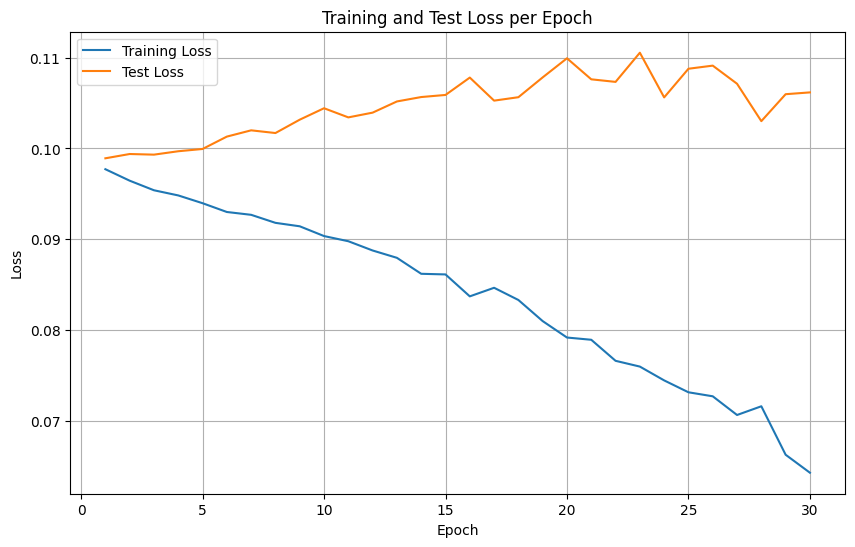

In [214]:
# Training loop
num_epochs = 30 # You can adjust the number of epochs

# Set the model to training mode & Move the model to device
model.train()
model.to(device)

# Lists to store losses for plotting later
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    print(f"Start Epoch [{epoch+1}/{num_epochs}]")

    running_loss = 0.0
    # Iterate over the training data in batches
    for batch, (img_clean, img_other, scores) in enumerate(train_dataloader, start=1):
        print(f"\rbatch {batch}/{len(train_dataloader)}", end='') # Print how many batchs are done
        # If not preloaded - Move batch data to the device
        if not train_dataset.preload:
            img_clean = img_clean.to(device)
            img_other = img_other.to(device)
            scores = scores.to(device).float() # Ensure scores are float and have shape (batch_size, 1)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        # Model outputs are now regression scores: (batch_size, 1)
        outputs = model(img_clean, img_other)

        # Calculate the loss (MSELoss for regression)
        loss = criterion(outputs, scores)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img_clean.size(0) # Accumulate loss, weighted by batch size

    print() # Newline after same-line batch number print
    # Calculate average epoch loss
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss) # Store training loss

    # Print training loss
    print(f"Average Training Loss: {epoch_loss:.4f}")


    # Evaluation on test data
    model.eval()
    test_running_loss = 0.0

    with torch.no_grad():
        for batch, (img_clean, img_other, scores) in enumerate(test_dataloader, start=1):
            print(f"\rbatch {batch}/{len(test_dataloader)}", end='') # Print how many batchs are done
            # If not preloaded - Move batch data to the device
            if not train_dataset.preload:
                img_clean = img_clean.to(device)
                img_other = img_other.to(device)
                scores = scores.to(device).float() # Ensure scores are float and have shape (batch_size, 1)

            test_outputs = model(img_clean, img_other)
            test_running_loss += criterion(test_outputs, scores).item() * img_clean.size(0) # Accumulate loss

    print() # Newline after same-line batch number print
    # Calculate average test loss
    test_loss = test_running_loss / len(test_dataset)
    test_losses.append(test_loss) # Store test loss


    print(f"Test Loss: {test_loss:.4f}")
    print(f"End Epoch [{epoch+1}/{num_epochs}]")


print("Training finished!")

# Optional: Plotting the training and test losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()


## Final Pass

In [197]:
# Set the model to evaluation mode
model.eval()

# Define the device: GPU if available, CPU otherwise
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model.to(device)

# Disable gradient calculation
with torch.no_grad():
    # --- Evaluate Loss on Training Set ---
    print("Calculating loss on training set...")
    train_running_loss = 0.0
    train_total_samples = 0

    for img_clean, img_other, scores in train_dataloader:
        # Ensure scores are float and on the correct device
        scores = scores.to(device).float()

        outputs = model(img_clean, img_other)
        # Clamp the outputs to the range [0, 1]
        outputs = torch.clamp(outputs, 0, 1)

        loss = criterion(outputs, scores)
        train_running_loss += loss.item() * img_clean.size(0)
        train_total_samples += img_clean.size(0)

    train_avg_loss = train_running_loss / train_total_samples
    print(f"Average Training Loss: {train_avg_loss:.4f}")


    # --- Evaluate Loss on Test Set ---
    print("\nCalculating loss on test set...")
    test_running_loss = 0.0
    test_total_samples = 0

    for img_clean, img_other, scores in test_dataloader:
        # Ensure scores are float and on the correct device
        scores = scores.to(device).float()

        outputs = model(img_clean, img_other)
        # Clamp the outputs to the range [0, 1]
        outputs = torch.clamp(outputs, 0, 1)

        loss = criterion(outputs, scores)
        test_running_loss += loss.item() * img_clean.size(0)
        test_total_samples += img_clean.size(0)

    test_avg_loss = test_running_loss / test_total_samples
    print(f"Average Test Loss: {test_avg_loss:.4f}")

Calculating loss on training set...
Average Training Loss: 0.0085

Calculating loss on test set...
Average Test Loss: 0.0244


## Save the model

In [198]:
# %%skip Comment out skip to save the model

# Define the path to save the model
model_save_path = os.path.join(project_path, 'src/saves/image_comparison_model_mk5_1.pth')

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/Colab Notebooks/Samsung/src/saves/image_comparison_model_mk5_1.pth


# Evaluation
Compute the confusion matrix for the test set predictions and true scores, using the bins [0-0.3, 0.3-0.6, 0.6-1] and the labels [RED, ORANGE, GREEN].

## Load The Model

In [220]:
from models import ImageComparisonModel_mk4 as ImageComparisonModel

# Load the trained model
model = ImageComparisonModel() # Instantiate the model first

# # mk_3_1 trail
model.forward = types.MethodType(new_forward, model)
print(model.forward.__name__)

model_save_path = os.path.join(project_path, 'src/saves/image_comparison_model_mk4_3.pth')
model.load_state_dict(torch.load(model_save_path))

print(f"Model loaded successfully from: {model_save_path}")

new_forward
Model loaded successfully from: /content/drive/MyDrive/Colab Notebooks/Samsung/src/saves/image_comparison_model_mk4_3.pth


## Run inference on the test set

Use the trained model to get predictions for all samples in the test dataset.


In [221]:
# Set the model to evaluation mode
model.eval()
model.to(device)

# Disable gradient calculation
with torch.no_grad():
    # Get predictions for the test set by iterating through the test_dataloader
    all_test_outputs = []
    all_test_scores = [] # Store true scores for evaluation

    for img_clean, img_other, scores in test_dataloader:
        # Move batch data to the device (if not preloaded)
        if not test_dataset.preload:
            img_clean = img_clean.to(device)
            img_other = img_other.to(device)
            scores = scores.to(device).float() # Ensure scores are float and have shape (batch_size, 1)


        test_outputs = model(img_clean, img_other)
        # Clamp the outputs to the range [0, 1]
        test_outputs = torch.clamp(test_outputs, 0, 1)

        all_test_outputs.append(test_outputs.cpu()) # Move to CPU for concatenation and later processing
        all_test_scores.append(scores.cpu()) # Move true scores to CPU

    # Concatenate all batch outputs and true scores
    all_test_outputs = torch.cat(all_test_outputs, dim=0)
    all_test_scores = torch.cat(all_test_scores, dim=0)


print("All test outputs shape:", all_test_outputs.shape)
print("All true test scores shape:", all_test_scores.shape)
print("Sample test outputs (predicted scores):", all_test_outputs[:5])
print("Sample true test scores:", all_test_scores[:5])

All test outputs shape: torch.Size([736])
All true test scores shape: torch.Size([736])
Sample test outputs (predicted scores): tensor([0.9259, 0.1245, 0.6924, 0.7717, 0.1041])
Sample true test scores: tensor([0.5000, 0.0000, 0.5000, 1.0000, 0.0000])


## Digitize predictions & true scores

Convert the continuous model outputs and the float testset labels into discrete labels.

bins `[0-0.3, 0.3-0.6, 0.6-1]`.


In [222]:
import numpy as np

bins = [0.3, 0.6, 1.0] # Define the upper bounds of the bins
# The right=True argument ensures that the rightmost bin includes the edge value (1.0)
predicted_class_indices = np.digitize(all_test_outputs.numpy().flatten(), bins, right=True)

print("Predicted class indices shape:", predicted_class_indices.shape)
print("Sample predicted class indices:", predicted_class_indices[:5])


true_class_indices = np.digitize(all_test_scores.numpy().flatten(), bins, right=True)

print("True class indices shape:", true_class_indices.shape)
print("Sample true class indices:", true_class_indices[:5])

Predicted class indices shape: (736,)
Sample predicted class indices: [2 0 2 2 0]
True class indices shape: (736,)
Sample true class indices: [1 0 1 2 0]


## Compute the confusion matrix

Calculate the confusion matrix comparing the digitized predictions and the digitized true scores.


In [223]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
# confusion_matrix expects true labels first, then predicted labels
# Use the class indices directly, as sklearn's confusion_matrix works with numerical labels
# Labels for the confusion matrix should be 0, 1, 2 corresponding to the bins.
conf_matrix = confusion_matrix(true_class_indices, predicted_class_indices, labels=[0, 1, 2])

# Print the confusion matrix
print("Confusion Matrix (Labels: 0=[0-0.3), 1=[0.3-0.6), 2=[0.6-1]):")
print(conf_matrix)

Confusion Matrix (Labels: 0=[0-0.3), 1=[0.3-0.6), 2=[0.6-1]):
[[346  30  11]
 [ 39  36  50]
 [  3   8 213]]


## Display the confusion matrix

Present the confusion matrix, potentially with labels [RED, ORANGE, GREEN] corresponding to the bins.

Using `ConfusionMatrixDisplay`.

Model Accuracy: 0.8084
Micro Precision: 0.8084, Micro Recall: 0.8084, Micro F1 Score: 0.8084
Macro Precision: 0.7185, Macro Recall: 0.7110, Macro F1 Score: 0.7034

Per-Class Metrics:
  [0-0.3):   Precision=0.8918, Recall=0.8941, F1 Score=0.8929, Support=387
  [0.3-0.6):   Precision=0.4865, Recall=0.2880, F1 Score=0.3618, Support=125
  [0.6-1]:   Precision=0.7774, Recall=0.9509, F1 Score=0.8554, Support=224


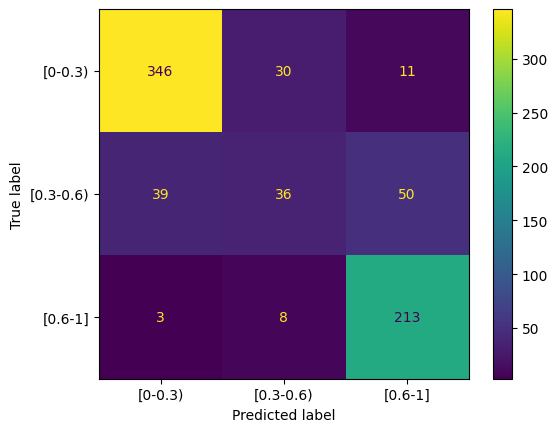

In [225]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np # Import numpy for digitize

# Calculate accuracy
accuracy = accuracy_score(true_class_indices, predicted_class_indices)

# Define labels for metrics and display
labels_names = ['[0-0.3)', '[0.3-0.6)', '[0.6-1]']
labels_indices = [0, 1, 2]

# Calculate precision, recall, and F1-score (micro and macro)
# We need to specify the labels and zero_division to handle cases with no predictions
precision_micro, recall_micro, fscore_micro, _ = precision_recall_fscore_support(
    true_class_indices, predicted_class_indices, average='micro', labels=labels_indices, zero_division=0
)
precision_macro, recall_macro, fscore_macro, _ = precision_recall_fscore_support(
    true_class_indices, predicted_class_indices, average='macro', labels=labels_indices, zero_division=0
)
# Also calculate per-class metrics for more detail
precision_per_class, recall_per_class, fscore_per_class, support_per_class = precision_recall_fscore_support(
    true_class_indices, predicted_class_indices, labels=labels_indices, zero_division=0
)


print(f"Model Accuracy: {accuracy:.4f}")
print(f"Micro Precision: {precision_micro:.4f}, Micro Recall: {recall_micro:.4f}, Micro F1 Score: {fscore_micro:.4f}")
print(f"Macro Precision: {precision_macro:.4f}, Macro Recall: {recall_macro:.4f}, Macro F1 Score: {fscore_macro:.4f}")
print("\nPer-Class Metrics:")
for i, label_name in enumerate(labels_names):
    print(f"  {label_name}:   Precision={precision_per_class[i]:.4f}, Recall={recall_per_class[i]:.4f}, F1 Score={fscore_per_class[i]:.4f}, Support={support_per_class[i]}")


# Create a display object for the confusion matrix
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels_names)

# Plot the confusion matrix
cmd.plot()

# Display the plot
plt.show()